In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config Completer.use_jedi = False        # For autocomplete to work!

In [2]:
sns.set(rc={'figure.figsize':(10,6)})
sns.set_style('whitegrid')
sns.set_palette('Set2')

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

# Project Tasks

**Read in the data set "Frozen_Dessert_Production.csv" from the Data folder. Figure out how to set the date to a datetime index columns**

In [3]:
df = pd.read_csv('data/Frozen_Dessert_Production.csv', parse_dates=True, index_col='DATE')

In [4]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [5]:
df.columns = ['Production']

In [6]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


**Plot out the time series**

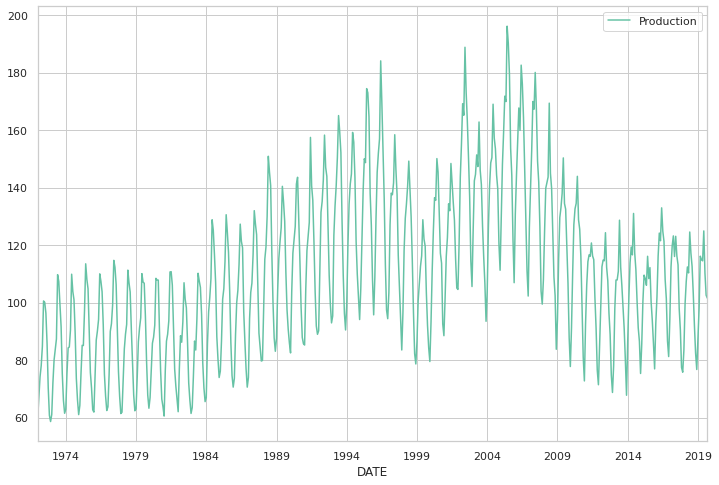

In [7]:
df.plot(figsize=(12,8));

## Train Test Split
---
**TASK: Figure out the length of the data set**

In [8]:
len(df)

573

**Split the data into a train/test split where the test set is the last 24 months of data.**

In [9]:
test_size = 24 #in months
test_index = len(df) - test_size

In [10]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [11]:
len(test)

24

## Scale Data
---

**Use a MinMaxScaler to scale the train and test sets into scaled versions.**

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()

In [14]:
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

**Create a TimeSeriesGenerator object based off the scaled_train data. The batch length is up to you, but as a minimum it should be at least 18 to capture a full year seasonality.**

In [15]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [16]:
length = 18
generator = TimeseriesGenerator(scaled_train, scaled_train,
                                length=length, batch_size = 1)

In [17]:
# What does the first batch look like?
X,y = generator[0]

In [18]:
len(generator)

531

In [19]:
# Where this number came from:
len(scaled_train) - length

531

In [20]:
print(f'Given the sequence:\n {X.flatten()}')
print(f'Try to predict:\n {y.flatten()}')

Given the sequence:
 [0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.
 0.01774221 0.09850931 0.15590133 0.18358944 0.20878908 0.37150354]
Try to predict:
 [0.3542551]


### Create the Model

**Create a Keras Sequential Model with as many LSTM units you want and a final Dense Layer.**

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [22]:
n_features = 1

In [23]:

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


**Create a generator for the scaled test/validation set. NOTE: Double check that your batch length makes sense for the size of the test set.**

In [25]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test,
                                           length = length, batch_size = 1)

**Create an EarlyStopping callback based on val_loss.**

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
early_stop = EarlyStopping(monitor='val_loss', patience = 3)

**Fit the model to the generator, let the EarlyStopping dictate the amount of epochs, so feel free to set the parameter high.**

In [33]:
model.fit(generator, epochs = 20,
          callbacks=[early_stop],
          validation_data=validation_generator)

Epoch 1/20
531/531 [==============================] - 2s 3ms/step - loss: 0.0030 - val_loss: 0.0039
Epoch 2/20
531/531 [==============================] - 2s 3ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 3/20
531/531 [==============================] - 2s 3ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 4/20
531/531 [==============================] - 2s 3ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 5/20
531/531 [==============================] - 2s 3ms/step - loss: 0.0030 - val_loss: 0.0022


**Plot the history of the loss that occured during training.**

In [29]:
losses = pd.DataFrame(model.history.history)

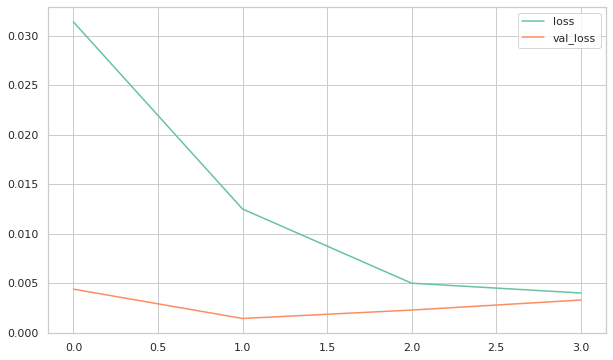

In [31]:
losses.plot();

## Evaluate on Test Data

**Forecast predictions for your test data range (the last `test_size` months of the entire dataset). Remember to inverse your scaling transformations. Your final result should be a DataFrame with two columns, the true test values and the predictions.**

In [34]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [35]:
true_predictions = scaler.inverse_transform(test_predictions)

In [36]:
test['Predictions'] = true_predictions

<ipython-input-36-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [37]:
test.head()

,Production,Predictions
DATE,,
2017-10-01,90.4732,91.290466
2017-11-01,77.4378,85.685560
2017-12-01,75.8118,87.206235
2018-01-01,83.4343,97.251288
2018-02-01,99.4899,107.302726


**Plot predictions versus the True test values.**

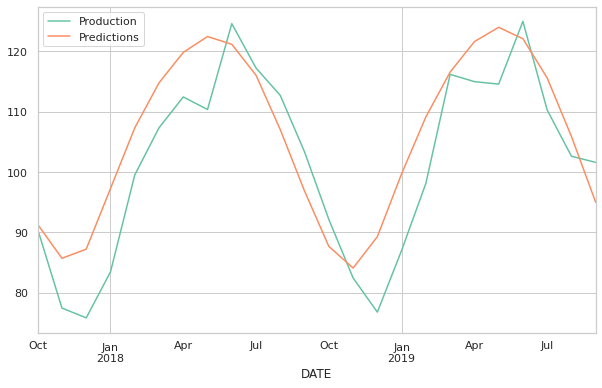

In [38]:
test.plot();

In [39]:
from sklearn.metrics import mean_squared_error

In [55]:
MSE = mean_squared_error(test['Production'], test['Predictions'])
RMSE = np.sqrt(MSE)

In [56]:
print(f'MSE:\n {MSE}')
print(f'RMSE:\n {RMSE}')

MSE:
 61.66835280242868
RMSE:
 7.852920017574907


# Retrain and Forecasting

In [42]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [43]:
length = 18
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data,
                                length = length, batch_size = 1)

In [44]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Can't use early stopping as there is no validation data for forecasting!
model.fit(generator,epochs=4)

Epoch 1/4
555/555 [==============================] - 2s 3ms/step - loss: 0.0272
Epoch 2/4
555/555 [==============================] - 2s 3ms/step - loss: 0.0072
Epoch 3/4
555/555 [==============================] - 2s 3ms/step - loss: 0.0043
Epoch 4/4
555/555 [==============================] - 2s 3ms/step - loss: 0.0035


## Forecasting into the unknown!

In [45]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [46]:
forecast = full_scaler.inverse_transform(forecast)

In [47]:
forecast

array([[ 90.36040721],
       [ 87.75960466],
       [ 91.77377118],
       [100.59839304],
       [111.49246098],
       [120.83975312],
       [127.1357956 ],
       [129.53191392],
       [127.09675992],
       [119.75619245],
       [108.7426651 ],
       [ 96.89004491]])

### Creating new timestamp index with pandas.
---

Original df:

In [49]:
df.tail()

,Production
DATE,
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632
2019-08-01,102.6085
2019-09-01,101.5866


In [50]:
# Forecast index starts one month after the last index of df:
forecast_index = pd.date_range(start='2019-10-01', periods = periods,
                               freq= 'MS')
# freq='MS' --> MonthlyStart

In [51]:
forecast_df = pd.DataFrame(data=forecast, index = forecast_index,
                           columns=['Forecast'])

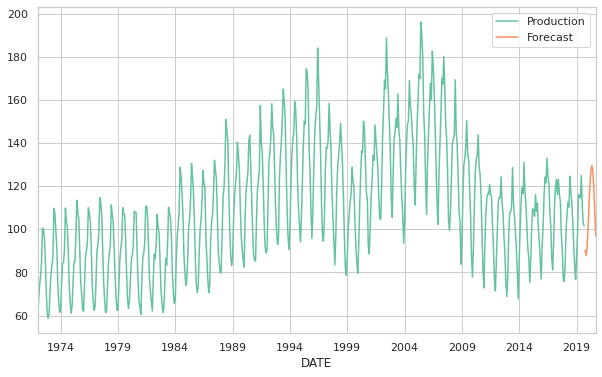

In [52]:
# Combining both plots on same ax:
ax = df.plot()
forecast_df.plot(ax=ax);

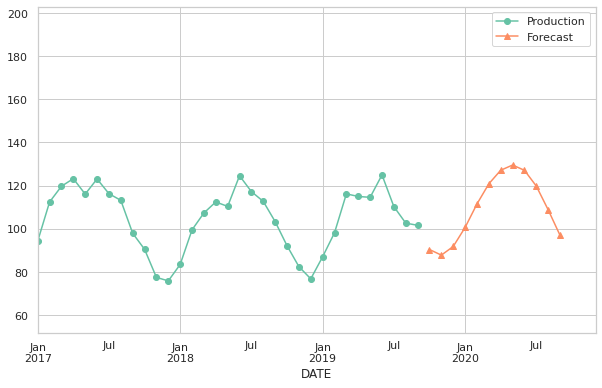

In [54]:
# Zooming in
ax = df.plot(style=['-o'])
forecast_df.plot(style=['-^'],ax=ax)
plt.xlim('2017-01-01','2020-12-01');